# 使用SymPy把模拟滤波器转换为数字滤波器

In [105]:
from sympy import *
from cytoolz import compose
init_printing()

巴特沃斯低通滤波器的传递函数可以用下面的公式表示：

$$H(s)=\frac{1}{\prod_{k=1}^n (s-s_k)/\omega_c}$$

$$s_k = \omega_c e^{\frac{j(2k+n - 1)\pi}{2n}}\qquad\mathrm{k = 1,2,3, \ldots, n}$$

下面使用SymPy计算$\omega_c$为1时的滤波器传递函数。

In [106]:
s = Symbol("s", real=True)

def butterworth(n, s):
    n = S(n)
    sk = [exp(I*(2*k+n-1)*pi / (2*n)) for k in range(S(1), n+1)]
    denominator = Mul(*[s - v for v in sk])
    simplify_func = compose(simplify, expand, simplify, expand_complex)
    Hs = 1 / simplify_func(denominator)
    return Hs

下面是2阶和3阶滤波器的传递函数：

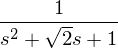

In [107]:
hs = butterworth(2, s)
hs

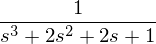

In [108]:
butterworth(3, s)

为了将标准的低通传递函数转换为任何圆频率$\omega_c$的传递函数，可以对$s$进行如下替换：

$$s \to \frac{s}{\omega_c}$$

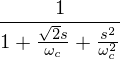

In [93]:
wc = Symbol("\omega_c", real=True)

def lp2lp(hs, s, wc):
    return hs.subs(s, s / wc)

hs2 = lp2lp(hs, s, wc)
hs2

有了连续时间系统的传递函数$H(s)$，下一步就是将它转换为离散时间系统的传递函数$H(z)$。转换的方法有几种，其中最常用的是双线性变换，其变换公式为：

$$s \leftarrow \frac{2}{T} \frac{z - 1}{z + 1}$$

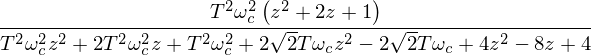

In [109]:
def bilinear(hs, s, z, T):
    hz = hs.subs(s, 2 / T * (z - 1) / (z + 1))
    simplify_func = compose(simplify, expand, simplify, expand)
    return simplify_func(hz)

z, T = symbols("z T", real=True)
hz = bilinear(hs2, s, z, T)
hz

为了计算数字滤波器的频率响应，需要进行如下替换，其中$\omega$为要计算相应的圆频率：

$$z=e^{j\omega T}$$

频率响应计算得到的是一个复数，它的幅值为增益，相角为相位。下面的`freqz()`函数返回复数的实部和虚部。

In [122]:
def freqz(hs, z, w, T):
    hz_freq = hz.subs(z, exp(I*w*T))
    exp_hz_freq = expand_complex(hz_freq)
    return simplify(re(exp_hz_freq)), simplify(im(exp_hz_freq))

In [123]:
w = Symbol("\omega", real=True)
re_hz_freq, im_hz_freq = freqz(hs, z, w, T)

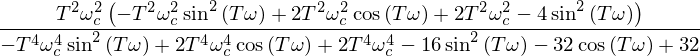

In [124]:
re_hz_freq

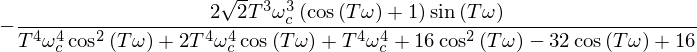

In [125]:
im_hz_freq

为了把上面的表达式转换为JavaScript代码，我们首先使用`cse()`对其进行分步运算。

In [129]:
steps, res = cse([re_hz_freq, im_hz_freq])
steps

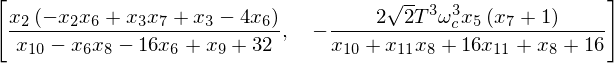

In [130]:
res

下面的函数使用`cse()`将表达式进行步骤分解，然后永`sympy.printing.jscode()`将各个步骤以及表示最终结果的表达式转换为JavaScript代码。

In [156]:
def to_javascript(funcname, args, expr):
    from sympy.printing import jscode
    steps, res = cse(expr, symbols=numbered_symbols("_tmp"))
    code = [
        "window.{} = function(args){{".format(funcname)
    ]
    
    for i, v in enumerate(args):
        code.append("var {} = args[{}];".format(str(v), i))
    
    for v, e in steps:
        code.append("var {} = {};".format(v, jscode(e)))
        
    code.append("return [{}];".format(", ".join(jscode(r) for r in res)))
    code.append("}")
    return "\n".join(code).replace("\\", "")

In [157]:
code = to_javascript("butter_lp_freqz", [T, w, wc], [re_hz_freq, im_hz_freq])
print(code)

window.butter_lp_freqz = function(args){
var T = args[0];
var omega = args[1];
var omega_c = args[2];
var _tmp0 = Math.pow(T, 2);
var _tmp1 = Math.pow(omega_c, 2);
var _tmp2 = _tmp0*_tmp1;
var _tmp3 = 2*_tmp0*_tmp1;
var _tmp4 = T*omega;
var _tmp5 = Math.sin(_tmp4);
var _tmp6 = Math.pow(_tmp5, 2);
var _tmp7 = Math.cos(_tmp4);
var _tmp8 = Math.pow(T, 4)*Math.pow(omega_c, 4);
var _tmp9 = 2*_tmp8;
var _tmp10 = _tmp7*_tmp9 - 32*_tmp7;
var _tmp11 = Math.pow(_tmp7, 2);
return [_tmp2*(-_tmp2*_tmp6 + _tmp3*_tmp7 + _tmp3 - 4*_tmp6)/(_tmp10 - _tmp6*_tmp8 - 16*_tmp6 + _tmp9 + 32), -2*Math.sqrt(2)*Math.pow(T, 3)*Math.pow(omega_c, 3)*_tmp5*(_tmp7 + 1)/(_tmp10 + _tmp11*_tmp8 + 16*_tmp11 + _tmp8 + 16)];
}


下面通过`IPython.display.display_javascript()`将上述JavaScript代码输出到Notebook中。

In [184]:
from IPython.display import display_javascript
display_javascript(code, raw=True)

In [185]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

最后调用本书提供的`make_curve_viewer()`显示滤波器的增益曲线。

In [186]:
from bokehelp import make_curve_viewer
import numpy as np

def freq_response(f, pars):
    w = 2 * Math.PI * f
    fs = pars["fs"]
    fc = pars["fc"]
    wc = 2 * Math.PI * fc
    T = 1 / fs
    re, im = butter_lp_freqz([T, w, wc])
    return dict(p=20*Math.log10(Math.sqrt(re*re + im*im)))

inputs = [dict(title="fs", start=1000, end=10000, step=1000, value=5000), 
          dict(title="fc", start=1, end=1000, step=1, value=100)]

outputs = [dict(name="p", legend="p", line_width=2)]

model = make_curve_viewer(freq_response, inputs, outputs, x_data=np.logspace(0, 4, 500), 
                          xlabel = "Freq(Hz)",
                          ylabel = "Gain(dB)",
                          fig_kwargs=dict(x_axis_type="log"))
show(model)

下面的`get_ba()`得到滤波器的系数`b`和`a`。

In [199]:
def get_ba(hz, z):
    n, d = fraction(hz)
    b = Matrix(Poly(n, z).coeffs())
    a = Matrix(Poly(d, z).coeffs())
    b = b / a[0]
    a = a / a[0]
    return list(b) + list(a)

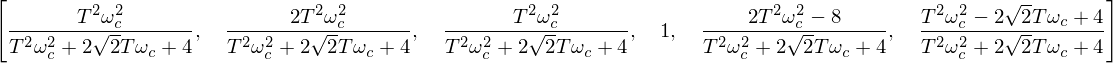

In [200]:
ba = get_ba(hz, z)
ba

将上面的表达式转换为JavaScript代码：

In [216]:
ba_code = to_javascript("butter_ba", [T, wc], ba)
display_javascript(ba_code, raw=True)
print(ba_code)

window.butter_ba = function(args){
var T = args[0];
var omega_c = args[1];
var _tmp0 = Math.pow(T, 2)*Math.pow(omega_c, 2);
var _tmp1 = 2*Math.sqrt(2)*T*omega_c;
var _tmp2 = _tmp0 + 4;
var _tmp3 = 1/(_tmp1 + _tmp2);
var _tmp4 = _tmp0*_tmp3;
var _tmp5 = 2*_tmp0;
return [_tmp4, _tmp3*_tmp5, _tmp4, 1, _tmp3*(_tmp5 - 8), _tmp3*(-_tmp1 + _tmp2)];
}


下面使用Bokeh的`DataTable`显示运算结果。

In [230]:
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn, Slider
from bokeh.io import output_file, show
from bokeh.layouts import column, row, widgetbox

data = dict(
        a=[0, 0, 0],
        b=[0, 0, 0],
    )
source = ColumnDataSource(data)

columns = [
        TableColumn(field="a", title="a"),
        TableColumn(field="b", title="b"),
    ]
data_table = DataTable(source=source, columns=columns, width=400, height=150)

sliders = [
    Slider(title="fs", start=1000, end=10000, step=1000, value=5000),
    Slider(title="fc", start=1, end=5000, step=1, value=100),
]

wbox = widgetbox(sliders)

def callback_func(source=source, wbox=wbox, table=data_table):
    window.table_t = table
    fs = wbox.children[0].value
    fc = wbox.children[1].value
    T = 1 / fs
    wc = 2 * Math.PI * fc
    ba = window.butter_ba([T, wc])
    source.data.a = ba[3:]
    source.data.b = ba[:3]
    source.change.emit()
    table.change.emit()
    
callback = CustomJS.from_py_func(callback_func)

for slider in sliders:
    slider.js_on_change("value", callback)

show(column(data_table, wbox))